# Value at Risk
## Introduction

Value at Risk. 

### Modeling the Value at Risk Problem

As a first step, we have to model the problem mathematically. We will use a simple yet powerful model, which captures the essence of portfolio optimization:

First, we will import the Python libraries required for this implementation. Classiq, of course, and Numpy. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from classiq import *

Now, we will define the parameters required for the Value at Risk process. 

In [2]:
# How many qubits we want the quantum circuit to be
num_qubits = 7

# Mu (μ) represents the Average
mu = 0.7

# Sigma (σ) represents the Standard Deviation
sigma = 0.13

# The Alpha (α) parameter represents the probability in which P(X > v) = 1 - α
ALPHA = 0.07

# Find Alpha in a given precision
TOLERANCE = ALPHA / 10

This is a classical approach to solve the Value at Risk problem.

2.030841014265948 0.07029323208790372 0.26512870853210846 1.2354548886696226 2.8262271398622736
Value at risk at 7%: 1.6613309244219858


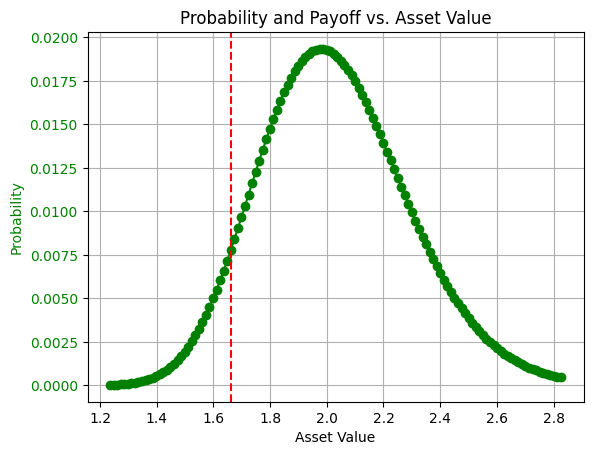

In [3]:
def get_log_normal_probabilities(mu_normal, sigma_normal, num_points):
    log_normal_mean = np.exp(mu + sigma**2 / 2)
    log_normal_variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    log_normal_stddev = np.sqrt(log_normal_variance)

    # cutting the distribution 3 sigmas from the mean
    low = np.maximum(0, log_normal_mean - 3 * log_normal_stddev)
    high = log_normal_mean + 3 * log_normal_stddev
    print(log_normal_mean, log_normal_variance, log_normal_stddev, low, high)
    x = np.linspace(low, high, num_points)
    return x, scipy.stats.lognorm.pdf(x, s=sigma_normal, scale=np.exp(mu_normal))


# %%
grid_points, probs = get_log_normal_probabilities(mu, sigma, 2**num_qubits)

probs = (probs / np.sum(probs)).tolist()

fig, ax1 = plt.subplots()

# Plotting the log-normal probability function
ax1.plot(grid_points, probs, "go-", label="Probability")  # Green line with circles
ax1.tick_params(axis="y", labelcolor="g")
ax1.set_xlabel("Asset Value")
ax1.set_ylabel("Probability", color="g")

# Adding grid and title
ax1.grid(True)
plt.title("Probability and Payoff vs. Asset Value")

VAR = 0
# Find the value at risk ALPHA of grid_points
accumulated_value = 0

for index in range(len(probs)):
    accumulated_value += probs[index]
    if accumulated_value > ALPHA:
        VAR = grid_points[index]
        break

print(f"Value at risk at {int(ALPHA*100)}%: {VAR}")

# Plot the vertical line of VaR at 5%
ax1.axvline(x=VAR, color="r", linestyle="--", label="VaR at 5%")

This is another classical way to solve the Value at Risk problem. We will analyse it in order to determine that the anticipated value is the same as the previous one, with the same data. Create the algorithm for calculating the VaR, given a function that estimates P[v]

In [4]:
# This function calculates the alpha given the index and the list of probabilities


def calc_alpha(index: int, probs: list[float]):
    sum_probs = sum([probs[i] for i in range(index)])
    return sum_probs

In [5]:
# This function searches for the required alpha, given the index and the current alpha.
# The search size will be added or substracted from the index as per the comparison.


def update_index(index: int, required_alpha: float, alpha_v: float, search_size: int):
    if alpha_v < required_alpha:
        return index + search_size
    return index - search_size

In [6]:
# This is the main Value at Risk function, which gets the required probability (required_alpha), the index and the alpha calculation function
# We aim to use calc_alpha defined above


def print_status(v, alpha_v, search_size, index):
    print(f"v: {v}, alpha_v: {alpha_v}")
    print(f"{search_size=}")
    print(f"{index=}")
    print("------------------------")


def value_at_risk(required_alpha, index, calc_alpha_func=calc_alpha):
    v = probs[index]
    alpha_v = calc_alpha_func(index, probs)
    search_size = index // 2
    print_status(v, alpha_v, search_size, index)

    # Tolerance represents the accuracy of the alpha we aim to get
    while (not np.isclose(alpha_v, required_alpha, atol=TOLERANCE)) and search_size > 0:
        index = update_index(index, required_alpha, alpha_v, search_size)
        # Binary search, divided by 2 - as we know the function is always growing in that part of the graph.
        search_size = search_size // 2
        v = grid_points[index]
        alpha_v = calc_alpha_func(index, probs)
        print_status(v, alpha_v, search_size, index)

    print(f"Value at risk at {ALPHA*100}%: {grid_points[index]})")
    print(f"Consecutive items are: ")
    print(f"{grid_points[index-1]}: {calc_alpha(index-1, probs)}")
    print(f"{grid_points[index]}: {calc_alpha(index, probs)}")
    print(f"{grid_points[index+1]}: {calc_alpha(index+1, probs)}")
    global VAR
    print(f"Real VaR", VAR)
    return index

In [7]:
def get_initial_index():
    return int(2**num_qubits) // 4


index = get_initial_index()
var_index = value_at_risk(ALPHA, index)

print(f"Calculated alpha: {calc_alpha(var_index, probs)}")

v: 0.0065948768440761245, alpha_v: 0.05208420102593402
search_size=16
index=32
------------------------
v: 1.8366916450259, alpha_v: 0.23233572478018774
search_size=8
index=48
------------------------
v: 1.7364855189665205, alpha_v: 0.12198155535389908
search_size=4
index=40
------------------------
v: 1.6863824559368308, alpha_v: 0.0820204268594856
search_size=2
index=36
------------------------
v: 1.6613309244219858, alpha_v: 0.06585414330510068
search_size=1
index=34
------------------------
Value at risk at 7.000000000000001%: 1.6613309244219858)
Consecutive items are: 
1.6488051586645633: 0.05867907787001014
1.6613309244219858: 0.06585414330510068
1.6738566901794083: 0.07362896410504041
Real VaR 1.6613309244219858
Calculated alpha: 0.06585414330510068


## Value at Risk using Iterative Quantum Amplitude Estimation (iQAE)

Iterative Quantum Amplitude Estimation (iQAE) is a key algorithm in the quantum computing toolbox. It is useful for quantum-enhanced Monte Carlo methods, which are in use for several important quantum finance applications like Value at Risk (VaR) estimation. 

The goal of Quantum Amplitude Estimation (QAE) is to estimate the probability (or amplitude) of a certain outcome from a quantum circuit. Compared to other classical methods, some has been presented above in this notebook - it is potentially quadratically faster.

iQAE is a NISQ-friendly version of the traditional Quantum Amplitude Estimation (QAE), and includes the following stages:

- State preparation encoding the desired probabilty, in this case - for not losing more than $X for an asset or a portfolio of asset.
- Use controlled applications of the Grover operator (unlike QAE, which utilises Fourier Transform)
- Measure and update the estimate using classical methods. 


In [8]:
# Defining the iterative quantum amplitude estimation algorithm


# This is a QStruct, containing an asset and an indicator, THAT MARKS THE AMPITUDE
class OptionPricingState(QStruct):
    asset: QNum[num_qubits, False, 0]
    ind: QBit


@qfunc
def iqae_algorithm(
    k: CInt,
    oracle_operand: QCallable[QArray[QBit]],
    sp_operand: QCallable[QArray[QBit]],  # sp=state preparation
    x: QArray[QBit],
):
    sp_operand(x)  # the call state preparation
    power(k, lambda: grover_operator(oracle_operand, sp_operand, x))  # iterative step


# Defining the oracle for the Grover operator - implement a Z gate on the qubit indicator
@qperm
def iqae_oracle(state: Const[OptionPricingState]):
    Z(state.ind)


@qfunc
def main(k: CInt, ind: Output[QBit]):
    state = OptionPricingState()
    allocate(num_qubits + 1, state)

    iqae_algorithm(
        k=k,
        oracle_operand=iqae_oracle,
        sp_operand=state_preparation,
        x=state,
    )
    asset = QNum(size=num_qubits)
    bind(state, [asset, ind])


@cfunc
def cmain():
    iqae_res = iqae(
        epsilon=0.05, alpha=0.01  # desired error  # desired probability for error
    )
    save({"iqae_res": iqae_res})

In [9]:
@qfunc(synthesize_separately=True)
def state_preparation(state: OptionPricingState):
    load_distribution(asset=state.asset)
    payoff(asset=state.asset, ind=state.ind)


@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)


def payoff(asset: QNum, ind: QBit):
    ind ^= asset < GLOBAL_INDEX

In [10]:
def calc_alpha_quantum(index: int, probs: list[float]):

    # Global variable
    global GLOBAL_INDEX
    GLOBAL_INDEX = index

    # Creation of the model, given the constratins and the circuit preferences
    qmod = create_model(
        main,
        constraints=Constraints(max_width=28, optimization_parameter="cx"),
        preferences=Preferences(machine_precision=num_qubits),
        classical_execution_function=cmain,
    )
    qprog = synthesize(qmod)
    write_qmod(main, decimal_precision=15, name="Persik")
    show(qprog)
    job = execute(qprog)
    res = job.result()

    # Result of the iterative QAE
    iqae_res = res[0].value
    measured_payoff = iqae_res.estimation
    confidence_interval = np.array(
        [interval for interval in iqae_res.confidence_interval]
    )
    print("Measured Payoff:", measured_payoff)
    print("Confidence Interval:", confidence_interval)
    return measured_payoff

In [11]:
index = get_initial_index()

In [12]:
var = value_at_risk(ALPHA, index, calc_alpha_quantum)

/Users/yigalilin/Cadmium/python_sdk/classiq/synthesis.py:60: ClassiqDeprecationWarning: The computation sequence of the local variable 'asset' includes a non-permutation operation
		at ipynb cell line 32 character 4 in function 'main'
  quantum_program.raise_warnings()


Quantum program link: https://platform.classiq.io/circuit/36pfSqCPtd21l0eV0VmQSyy98zq
Measured Payoff: 0.05157964256496006
Confidence Interval: [0.04693301 0.05622628]
v: 0.0065948768440761245, alpha_v: 0.05157964256496006
search_size=16
index=32
------------------------
Quantum program link: https://platform.classiq.io/circuit/36pfXGubttm0tcBpElcLXCnGpcm
Measured Payoff: 0.2392578125
Confidence Interval: [0.19973882 0.2787768 ]
v: 1.8366916450259, alpha_v: 0.2392578125
search_size=8
index=48
------------------------
Quantum program link: https://platform.classiq.io/circuit/36pfbqs9OyWZtz7IgrTQ5wNUSxL
Measured Payoff: 0.1219835848054534
Confidence Interval: [0.11813249 0.12583468]
v: 1.7364855189665205, alpha_v: 0.1219835848054534
search_size=4
index=40
------------------------
Quantum program link: https://platform.classiq.io/circuit/36pfgTzn06YIvYtGARUQ8It1QMk
Measured Payoff: 0.08337477159701194
Confidence Interval: [0.07955472 0.08719482]
v: 1.6863824559368308, alpha_v: 0.083374771